In [1]:
reset -fs

In [5]:
import sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob as tb
from autocorrect import spell

In [8]:
review_fn = "/Users/7of9/Documents/Machine_Learning/yelp-dataset-data/yelp_academic_dataset_review.json"
with open(review_fn, 'r', encoding='UTF-8') as f:
    rev_data = f.readlines()
    rev_data = list(map(json.loads, rev_data))
    
rev_df = pd.DataFrame(rev_data)

In [9]:
business_fn = '/Users/7of9/Documents/Machine_Learning/yelp-dataset-data/yelp_academic_dataset_business.json'

with open(business_fn, 'r', encoding='UTF-8') as f:
    bus_data = f.readlines()
    bus_data = list(map(json.loads, bus_data))

bus_df = pd.DataFrame(bus_data)[
    ['business_id', 'categories', 'city', 'name', 'review_count', 'stars']]

In [10]:
bus_df = bus_df[bus_df.categories.str.contains('Restaurant|Food', na=False)]

rest_df = rev_df.merge(bus_df, how='inner', left_on='business_id',
                       right_on='business_id', suffixes=('_rev', '_rest'))

In [18]:
# number of users by review count
usr_rev_count = rest_df.groupby('user_id')['review_id'].count()
usr_rev_count.head()

user_id
---1lKK3aKOuomHnwAkAow    70
---94vtJ_5o_nikEs6hUjg     1
---PLwSf5gKdIoVnyRHgBA     1
---cu1hq55BP9DWVXXKHZg     2
---udAKDsn0yQXmzbWQNSw     2
Name: review_id, dtype: int64

In [21]:
print(usr_rev_count.describe())

count    1.073841e+06
mean     3.742384e+00
std      1.208344e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      3.057000e+03
Name: review_id, dtype: float64


Text(0.5, 1.0, 'Above 100 Reviews')

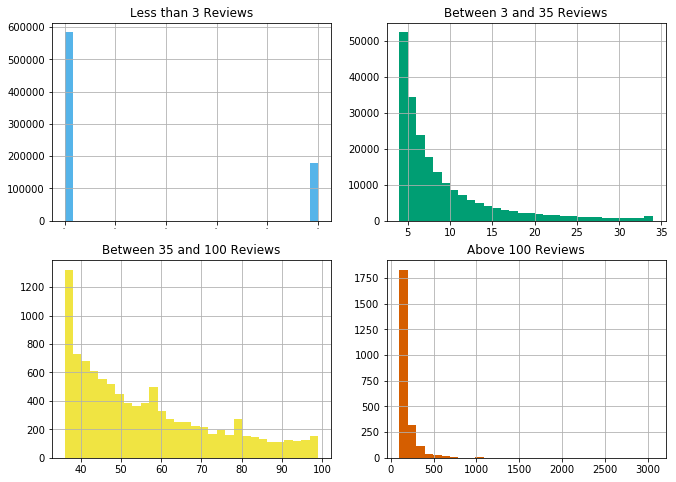

In [66]:
# number of users by review count
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(11,8)
# '#56B4E9', '#009E73', '#F0E442', '#D55E00']
usr_rev_count[usr_rev_count < 3].hist(ax=axes[0,0],xlabelsize=2, color='#56B4E9', bins=30).set_title("Less than 3 Reviews")
usr_rev_count[(usr_rev_count > 3) & (usr_rev_count < 35)].hist(ax=axes[0,1], color ='#009E73', bins=30).set_title("Between 3 and 35 Reviews")
usr_rev_count[(usr_rev_count > 35) & (usr_rev_count < 100)].hist(ax=axes[1,0], color='#F0E442', bins=30).set_title("Between 35 and 100 Reviews")
usr_rev_count[(usr_rev_count > 100)].hist(ax=axes[1,1], color='#D55E00', bins=30).set_title("Above 100 Reviews")

In [23]:
rest_df['usr_rev_count'] = rest_df.groupby('user_id')['review_id'].transform('count')
rest_df_smpl = rest_df[(rest_df.usr_rev_count > 10) & (rest_df.usr_rev_count < 20)]

In [24]:
rest_df_smpl['stars_delta'] = rest_df_smpl.stars_rev - rest_df_smpl.stars_rest
rest_df_smpl['avg_star_delta'] = rest_df_smpl.groupby(['user_id'])['stars_delta'].transform('mean')

/Users/7of9/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/7of9/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0, 0.5, 'Number of Users')

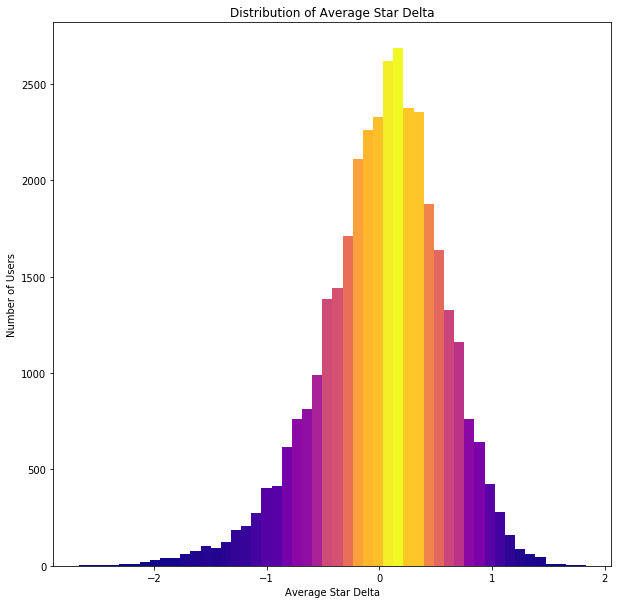

In [53]:
from matplotlib import colors 
usr_deltas = rest_df_smpl[['user_id','avg_star_delta']].drop_duplicates()
x2 = usr_deltas['avg_star_delta']

fig, ax = plt.subplots(figsize=(10, 10))
N, bins, patches = ax.hist(x2, bins=50)
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.plasma(norm(thisfrac)) #viridis
    thispatch.set_facecolor(color)
ax.set_title('Distribution of Average Star Delta')
ax.set_xlabel('Average Star Delta')
ax.set_ylabel('Number of Users')

In [54]:
# number of easy, med, hard reviews
print(len(rest_df_smpl[rest_df_smpl.avg_star_delta < -0.5]))
print(len(rest_df_smpl[(rest_df_smpl.avg_star_delta > -0.5) & (rest_df_smpl.avg_star_delta < 0.5)]))
print(len(rest_df_smpl[rest_df_smpl.avg_star_delta > 0.5]))

73403
319339
81423


In [55]:
df_by_usr = rest_df_smpl.groupby(['user_id', 'avg_star_delta'])['text'].sum().reset_index(name='text_agg')
df_by_usr['reviewer_label'] = pd.cut(df_by_usr['avg_star_delta'], bins=[-5,-0.5,.5,5], include_lowest=False, labels=['hard', 'med', 'easy'])

In [56]:
# number of easy, med, hard reviewers
hard = sum(df_by_usr['reviewer_label'] == 'easy')
med = sum(df_by_usr['reviewer_label'] == 'med')
easy = sum(df_by_usr['reviewer_label'] == 'hard')
print(hard)
print(med)
print(easy)
print(med/len(df_by_usr))

5910
23403
5738
0.6676842315483154


In [57]:
# distribution of review length
rest_df_smpl['rev_len'] = rest_df_smpl.text.apply(lambda x: len(x))

/Users/7of9/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0, 0.5, 'Number of Reviews')

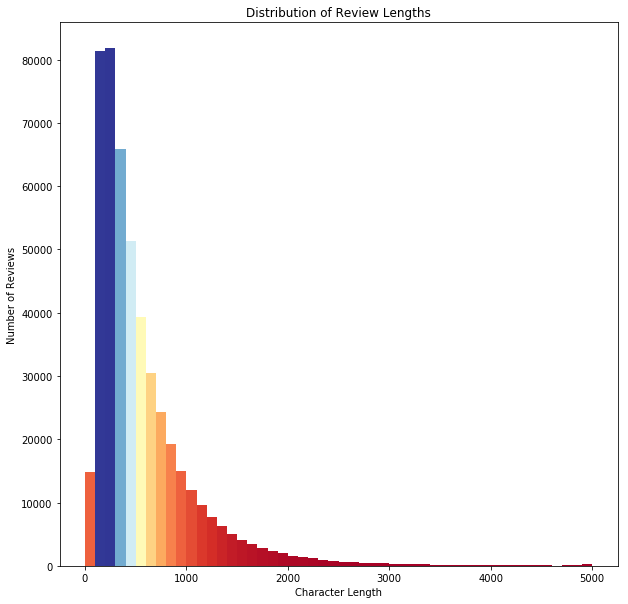

In [64]:
from matplotlib import colors 
x3 = rest_df_smpl['rev_len']

fig, ax = plt.subplots(figsize=(10, 10))
N, bins, patches = ax.hist(x3, bins=50)
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.RdYlBu(norm(thisfrac)) 
    thispatch.set_facecolor(color)
ax.set_title('Distribution of Review Lengths')
ax.set_xlabel('Character Length')
ax.set_ylabel('Number of Reviews')